<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%EB%88%84%EC%88%98%20%ED%83%90%EC%A7%80%20%EA%B8%B0%EC%97%85%EC%9D%98%20%EC%8B%A0%EC%82%AC%EC%97%85%20%ED%9A%A8%EC%9A%A9%EC%84%B1%20%ED%8F%89%EA%B0%80/SVM(rbf%2C%20poly%20kernel)%20%EB%B6%84%EB%A5%98%20%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_m = pd.read_csv('/content/drive/MyDrive/센서 데이터.csv', encoding='cp949')
df_m.head(10)

first_row = df_m.iloc[0]
price_df = pd.DataFrame([first_row])

df = df_m.drop(0, axis=0)

first_row = df_m.iloc[0]
price_df = pd.DataFrame([first_row])

df.iloc[:, -1] = df.iloc[:, -1].map({'Y': 1, 'N': 0})

In [ ]:
price_df

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,Y
0,가격,11400.0,11100.0,14400.0,12300.0,15300.0,13200.0,11100.0,4500.0,6300.0,...,8700.0,11700.0,13500.0,4500.0,11100.0,11400.0,9600.0,9900.0,9000.0,NaN


In [ ]:
X_selected = df.iloc[:, 1:-1].iloc[:, [10, 15, 31]]

In [ ]:
X_selected

,11,16,32
1,0.1609,0.2273,0.2604
2,0.4918,0.9444,0.2947
3,0.6333,0.6931,0.5045
4,0.0881,0.2131,0.7340
5,0.4152,0.5326,0.5459
...,...,...,...
204,0.3108,0.2200,0.5547
205,0.3085,0.1534,0.7117
206,0.2716,0.1503,0.7305
207,0.2898,0.1444,0.4961


         11      16      32
1    0.1609  0.2273  0.2604
2    0.4918  0.9444  0.2947
3    0.6333  0.6931  0.5045
4    0.0881  0.2131  0.7340
5    0.4152  0.5326  0.5459
..      ...     ...     ...
204  0.3108  0.2200  0.5547
205  0.3085  0.1534  0.7117
206  0.2716  0.1503  0.7305
207  0.2898  0.1444  0.4961
208  0.2720  0.1708  0.4567

[208 rows x 3 columns]
0.8333333333333334 [[15  6]
 [ 1 20]]


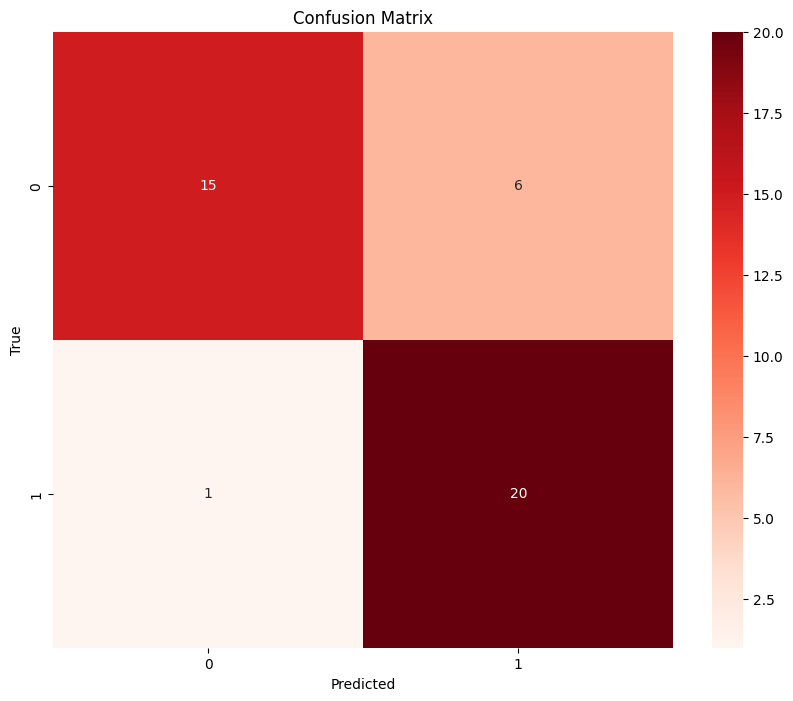

In [ ]:
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 0번째와 마지막 열을 제외한 후, 10, 15, 31번 인덱스에 해당하는 열만 선택
X_selected = df.iloc[:, 1:-1].iloc[:, [10, 15, 31]]
y = df.iloc[:, -1]  # 누수 여부

# 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# SVM 모델 구성 및 훈련
svm_model = SVC(kernel='rbf', C=2.686708)
svm_model.fit(X_train, y_train)

# 테스트 데이터에 대한 성능 평가
y_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)
print(X_selected )
print(test_accuracy, conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 데이터 로드 (X, y, 가격 정보)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# 데이터를 트레이닝 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 성능 평가 함수
def evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, kernel_type):
    model = SVC(kernel=kernel_type)
    model.fit(X_train.iloc[:, list(combination)], y_train)
    predictions = model.predict(X_test.iloc[:, list(combination)])
    accuracy = accuracy_score(y_test, predictions)

    # FPR과 FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return accuracy, fpr, fnr

# 정확도 기준 0.65로 했더니 너무 많이 나와서 0.7로 바꿈.
threshold = 0.70

# 결과 데이터 프레임 초기화
results_rbf2 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])
results_poly2 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])

for combination in itertools.combinations(range(X_train.shape[1]), 2):
    acc_rbf, fpr_rbf, fnr_rbf = evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, 'rbf')
    if acc_rbf > threshold:
        results_rbf2 = pd.concat([results_rbf2, pd.DataFrame([{'Combination': combination, 'Accuracy': acc_rbf, 'FPR': fpr_rbf, 'FNR': fnr_rbf}])], ignore_index=True)

    acc_poly, fpr_poly, fnr_poly = evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, 'poly')
    if acc_poly > threshold:
        results_poly2 = pd.concat([results_poly2, pd.DataFrame([{'Combination': combination, 'Accuracy': acc_poly, 'FPR': fpr_poly, 'FNR': fnr_poly}])], ignore_index=True)

print("RBF 조합 결과:")
print(results_rbf2)
print("\nPoly 조합 결과:")
print(results_poly2)

RBF 조합 결과:
    Combination  Accuracy       FPR       FNR
0       (0, 10)  0.761905  0.428571  0.047619
1       (0, 44)  0.738095  0.285714  0.238095
2        (1, 8)  0.738095  0.380952  0.142857
3       (1, 10)  0.761905  0.428571  0.047619
4       (1, 44)  0.714286  0.333333  0.238095
..          ...       ...       ...       ...
150    (45, 56)  0.714286  0.428571  0.142857
151    (45, 57)  0.738095  0.428571  0.095238
152    (45, 58)  0.714286  0.428571  0.142857
153    (45, 59)  0.714286  0.428571  0.142857
154    (50, 55)  0.714286  0.333333  0.238095

[155 rows x 4 columns]

Poly 조합 결과:
   Combination  Accuracy       FPR       FNR
0      (0, 27)  0.714286  0.333333  0.238095
1      (1, 27)  0.714286  0.238095  0.333333
2      (1, 47)  0.714286  0.142857  0.428571
3      (1, 48)  0.714286  0.142857  0.428571
4      (2, 10)  0.761905  0.047619  0.428571
..         ...       ...       ...       ...
71    (27, 44)  0.761905  0.047619  0.428571
72    (27, 46)  0.714286  0.190476  0.38

In [ ]:
results_rbf2

,Combination,Accuracy,FPR,FNR
0,"(0, 10)",0.761905,0.428571,0.047619
1,"(0, 44)",0.738095,0.285714,0.238095
2,"(1, 8)",0.738095,0.380952,0.142857
3,"(1, 10)",0.761905,0.428571,0.047619
4,"(1, 44)",0.714286,0.333333,0.238095
...,...,...,...,...
150,"(45, 56)",0.714286,0.428571,0.142857
151,"(45, 57)",0.738095,0.428571,0.095238
152,"(45, 58)",0.714286,0.428571,0.142857
153,"(45, 59)",0.714286,0.428571,0.142857


In [ ]:
results_poly2

,Combination,Accuracy,FPR,FNR
0,"(0, 27)",0.714286,0.333333,0.238095
1,"(1, 27)",0.714286,0.238095,0.333333
2,"(1, 47)",0.714286,0.142857,0.428571
3,"(1, 48)",0.714286,0.142857,0.428571
4,"(2, 10)",0.761905,0.047619,0.428571
...,...,...,...,...
71,"(27, 44)",0.761905,0.047619,0.428571
72,"(27, 46)",0.714286,0.190476,0.380952
73,"(27, 47)",0.738095,0.190476,0.333333
74,"(27, 48)",0.761905,0.190476,0.285714


In [ ]:
# 데이터를 트레이닝 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 성능 평가 함수
def evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, kernel_type):
    model = SVC(kernel=kernel_type)
    model.fit(X_train.iloc[:, list(combination)], y_train)
    predictions = model.predict(X_test.iloc[:, list(combination)])
    accuracy = accuracy_score(y_test, predictions)

    # FPR과 FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return accuracy, fpr, fnr

threshold_3 = 0.8

# 3개 센서 조합의 성능 평가를 위한 데이터 프레임 초기화
results_rbf3 = pd.DataFrame(columns=['Combination', 'Accuracy','FPR', 'FNR'])
results_poly3 = pd.DataFrame(columns=['Combination', 'Accuracy','FPR', 'FNR'])

# RBF 커널에 대한 3개 센서 조합 평가
for combination in results_rbf2['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_rbf, fpr_rbf, fnr_rbf = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'rbf')
            if acc_rbf > threshold_3:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_rbf, 'FPR': fpr_rbf, 'FNR': fnr_rbf}])
                results_rbf3 = pd.concat([results_rbf3, new_row], ignore_index=True)

# Poly 커널에 대한 3개 센서 조합 평가
for combination in results_poly2['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_poly, fpr_poly, fnr_poly = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'poly')
            if acc_poly > threshold_3:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_poly, 'FPR': fpr_poly, 'FNR': fnr_poly}])
                results_poly3 = pd.concat([results_poly3, new_row], ignore_index=True)


print("RBF 3개 센서 조합 결과:")
print(results_rbf3)
print("\nPoly 3개 센서 조합 결과:")
print(results_poly3)

RBF 3개 센서 조합 결과:
     Combination  Accuracy       FPR       FNR
0    (0, 10, 33)  0.809524  0.333333  0.047619
1     (0, 4, 44)  0.809524  0.285714  0.095238
2    (1, 10, 33)  0.809524  0.333333  0.047619
3     (1, 4, 44)  0.809524  0.285714  0.095238
4    (1, 39, 44)  0.809524  0.285714  0.095238
..           ...       ...       ...       ...
197  (4, 44, 57)  0.809524  0.285714  0.095238
198  (4, 44, 58)  0.809524  0.285714  0.095238
199  (4, 44, 59)  0.809524  0.285714  0.095238
200  (2, 45, 47)  0.833333  0.285714  0.047619
201  (4, 45, 47)  0.833333  0.285714  0.047619

[202 rows x 4 columns]

Poly 3개 센서 조합 결과:
      Combination  Accuracy       FPR       FNR
0      (1, 8, 27)  0.857143  0.047619  0.238095
1     (1, 12, 27)  0.809524  0.333333  0.047619
2     (1, 27, 44)  0.809524  0.047619  0.333333
3     (1, 10, 47)  0.809524  0.142857  0.238095
4     (1, 26, 48)  0.809524  0.142857  0.238095
..            ...       ...       ...       ...
214  (10, 27, 48)  0.833333  0.285714  0

너무 많이 나오네? 기준치를 올리자.

In [ ]:
results_rbf3

,Combination,Accuracy,FPR,FNR
0,"(0, 10, 33)",0.809524,0.333333,0.047619
1,"(0, 4, 44)",0.809524,0.285714,0.095238
2,"(1, 10, 33)",0.809524,0.333333,0.047619
3,"(1, 4, 44)",0.809524,0.285714,0.095238
4,"(1, 39, 44)",0.809524,0.285714,0.095238
...,...,...,...,...
197,"(4, 44, 57)",0.809524,0.285714,0.095238
198,"(4, 44, 58)",0.809524,0.285714,0.095238
199,"(4, 44, 59)",0.809524,0.285714,0.095238
200,"(2, 45, 47)",0.833333,0.285714,0.047619


In [ ]:
results_poly3

,Combination,Accuracy,FPR,FNR
0,"(1, 8, 27)",0.857143,0.047619,0.238095
1,"(1, 12, 27)",0.809524,0.333333,0.047619
2,"(1, 27, 44)",0.809524,0.047619,0.333333
3,"(1, 10, 47)",0.809524,0.142857,0.238095
4,"(1, 26, 48)",0.809524,0.142857,0.238095
...,...,...,...,...
214,"(10, 27, 48)",0.833333,0.285714,0.047619
215,"(8, 27, 50)",0.833333,0.095238,0.238095
216,"(9, 27, 50)",0.809524,0.142857,0.238095
217,"(10, 27, 50)",0.809524,0.238095,0.142857


In [ ]:
# 데이터를 트레이닝 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 성능 평가 함수
def evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, kernel_type):
    model = SVC(kernel=kernel_type)
    model.fit(X_train.iloc[:, list(combination)], y_train)
    predictions = model.predict(X_test.iloc[:, list(combination)])
    accuracy = accuracy_score(y_test, predictions)

    # FPR과 FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return accuracy, fpr, fnr

# 4개 센서 조합의 성능 평가를 위한 데이터 프레임 초기화
results_rbf4 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])
results_poly4 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])

threshold_4 = 0.85

# RBF 커널에 대한 4개 센서 조합 평가
for combination in results_rbf3['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_rbf, fpr_rbf, fnr_rbf = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'rbf')
            if acc_rbf > threshold_4:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_rbf, 'FPR': fpr_rbf, 'FNR': fnr_rbf}])
                results_rbf4 = pd.concat([results_rbf4, new_row], ignore_index=True)

# Poly 커널에 대한 4개 센서 조합 평가
for combination in results_poly3['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_poly, fpr_poly, fnr_poly = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'poly')
            if acc_poly > threshold_4:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_poly, 'FPR': fpr_poly, 'FNR': fnr_poly}])
                results_poly4 = pd.concat([results_poly4, new_row], ignore_index=True)

In [ ]:
results_rbf4

,Combination,Accuracy,FPR,FNR
0,"(0, 4, 39, 44)",0.880952,0.190476,0.047619
1,"(3, 10, 16, 33)",0.857143,0.238095,0.047619
2,"(3, 41, 44, 47)",0.880952,0.190476,0.047619
3,"(0, 4, 39, 44)",0.880952,0.190476,0.047619
4,"(0, 4, 39, 44)",0.880952,0.190476,0.047619
...,...,...,...,...
318,"(4, 44, 45, 47)",0.857143,0.285714,0.000000
319,"(4, 39, 44, 47)",0.857143,0.285714,0.000000
320,"(39, 44, 47, 48)",0.857143,0.190476,0.095238
321,"(4, 39, 45, 47)",0.857143,0.238095,0.047619


In [ ]:
results_poly4

,Combination,Accuracy,FPR,FNR
0,"(1, 2, 8, 27)",0.857143,0.047619,0.238095
1,"(1, 3, 8, 27)",0.857143,0.095238,0.190476
2,"(1, 8, 12, 27)",0.857143,0.190476,0.095238
3,"(1, 8, 27, 40)",0.857143,0.047619,0.238095
4,"(1, 8, 27, 48)",0.857143,0.190476,0.095238
...,...,...,...,...
594,"(8, 27, 50, 56)",0.857143,0.047619,0.238095
595,"(8, 27, 50, 57)",0.857143,0.047619,0.238095
596,"(8, 27, 50, 58)",0.857143,0.047619,0.238095
597,"(8, 27, 50, 59)",0.857143,0.047619,0.238095


In [ ]:
# 데이터를 트레이닝 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 성능 평가 함수
def evaluate_combination_performance(combination, X_train, X_test, y_train, y_test, kernel_type):
    model = SVC(kernel=kernel_type)
    model.fit(X_train.iloc[:, list(combination)], y_train)
    predictions = model.predict(X_test.iloc[:, list(combination)])
    accuracy = accuracy_score(y_test, predictions)

    # FPR과 FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return accuracy, fpr, fnr

threshold_5 = 0.88

# 5개 센서 조합의 성능 평가를 위한 데이터 프레임 초기화
results_rbf5 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])
results_poly5 = pd.DataFrame(columns=['Combination', 'Accuracy', 'FPR', 'FNR'])

# RBF 커널에 대한 5개 센서 조합 평가
for combination in results_rbf4['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_rbf, fpr_rbf, fnr_rbf = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'rbf')
            if acc_rbf > threshold_5:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_rbf, 'FPR': fpr_rbf, 'FNR': fnr_rbf}])
                results_rbf5 = pd.concat([results_rbf5, new_row], ignore_index=True)

# Poly 커널에 대한 5개 센서 조합 평가
for combination in results_poly4['Combination']:
    for new_sensor in range(X_train.shape[1]):
        if new_sensor not in combination:
            new_combination = tuple(sorted(combination + (new_sensor,)))
            acc_poly, fpr_poly, fnr_poly = evaluate_combination_performance(new_combination, X_train, X_test, y_train, y_test, 'poly')
            if acc_poly > threshold_5:
                new_row = pd.DataFrame([{'Combination': new_combination, 'Accuracy': acc_poly, 'FPR': fpr_poly, 'FNR': fnr_poly}])
                results_poly5 = pd.concat([results_poly5, new_row], ignore_index=True)

In [ ]:
results_rbf5

,Combination,Accuracy,FPR,FNR
0,"(0, 3, 41, 44, 47)",0.880952,0.190476,0.047619
1,"(3, 41, 44, 47, 49)",0.880952,0.190476,0.047619
2,"(3, 41, 44, 47, 50)",0.880952,0.190476,0.047619
3,"(3, 41, 44, 47, 51)",0.880952,0.190476,0.047619
4,"(3, 41, 44, 47, 52)",0.880952,0.190476,0.047619
...,...,...,...,...
2464,"(39, 44, 47, 48, 55)",0.880952,0.190476,0.047619
2465,"(39, 44, 47, 48, 56)",0.880952,0.190476,0.047619
2466,"(39, 44, 47, 48, 57)",0.880952,0.190476,0.047619
2467,"(39, 44, 47, 48, 58)",0.880952,0.190476,0.047619


In [ ]:
print(len(results_poly5))

3017


In [ ]:
# 중복제거
results_rbf2_unique = results_rbf2.drop_duplicates(subset=['Combination'])
results_rbf3_unique = results_rbf3.drop_duplicates(subset=['Combination'])
results_rbf4_unique = results_rbf4.drop_duplicates(subset=['Combination'])
results_rbf5_unique = results_rbf5.drop_duplicates(subset=['Combination'])

results_poly2_unique = results_poly2.drop_duplicates(subset=['Combination'])
results_poly3_unique = results_poly3.drop_duplicates(subset=['Combination'])
results_poly4_unique = results_poly4.drop_duplicates(subset=['Combination'])
results_poly5_unique = results_poly5.drop_duplicates(subset=['Combination'])

In [ ]:
print(len(results_poly5_unique))

833


In [ ]:
combined_rbf = pd.concat([results_rbf2_unique, results_rbf3_unique, results_rbf4_unique, results_rbf5_unique])

In [ ]:
combined_poly = pd.concat([results_poly2_unique, results_poly3_unique, results_poly4_unique, results_poly5_unique])

In [ ]:
combined_rbf

,Combination,Accuracy,FPR,FNR
0,"(0, 10)",0.761905,0.428571,0.047619
1,"(0, 44)",0.738095,0.285714,0.238095
2,"(1, 8)",0.738095,0.380952,0.142857
3,"(1, 10)",0.761905,0.428571,0.047619
4,"(1, 44)",0.714286,0.333333,0.238095
...,...,...,...,...
2418,"(39, 44, 47, 48, 55)",0.880952,0.190476,0.047619
2419,"(39, 44, 47, 48, 56)",0.880952,0.190476,0.047619
2420,"(39, 44, 47, 48, 57)",0.880952,0.190476,0.047619
2421,"(39, 44, 47, 48, 58)",0.880952,0.190476,0.047619


In [ ]:
combined_poly

,Combination,Accuracy,FPR,FNR
0,"(0, 27)",0.714286,0.333333,0.238095
1,"(1, 27)",0.714286,0.238095,0.333333
2,"(1, 47)",0.714286,0.142857,0.428571
3,"(1, 48)",0.714286,0.142857,0.428571
4,"(2, 10)",0.761905,0.047619,0.428571
...,...,...,...,...
2183,"(1, 8, 24, 25, 47)",0.880952,0.190476,0.047619
2210,"(9, 16, 26, 36, 46)",0.880952,0.142857,0.095238
2595,"(9, 27, 38, 39, 44)",0.880952,0.095238,0.142857
2597,"(3, 9, 27, 40, 44)",0.880952,0.095238,0.142857


In [ ]:
# 필요없는 열 제거
price_df = price_df.drop(columns=['Unnamed: 0', 'Y'])

# 각 센서 조합의 총 가격을 계산하는 함수
def calculate_total_price(combination, prices):
    return sum(prices.iloc[0, sensor] for sensor in combination)

# combined_rbf 데이터 프레임에 총 가격 열 추가
combined_rbf['Total Price'] = combined_rbf['Combination'].apply(lambda x: calculate_total_price(x, price_df))

# combined_poly 데이터 프레임에 총 가격 열 추가
combined_poly['Total Price'] = combined_poly['Combination'].apply(lambda x: calculate_total_price(x, price_df))

In [ ]:
price_df

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,11400.0,11100.0,14400.0,12300.0,15300.0,13200.0,11100.0,4500.0,6300.0,11100.0,...,14400.0,8700.0,11700.0,13500.0,4500.0,11100.0,11400.0,9600.0,9900.0,9000.0


In [ ]:
combined_rbf

,Combination,Accuracy,FPR,FNR,Total Price
0,"(0, 10)",0.761905,0.428571,0.047619,34800.0
1,"(0, 44)",0.738095,0.285714,0.238095,15600.0
2,"(1, 8)",0.738095,0.380952,0.142857,17400.0
3,"(1, 10)",0.761905,0.428571,0.047619,34500.0
4,"(1, 44)",0.714286,0.333333,0.238095,15300.0
...,...,...,...,...,...
2418,"(39, 44, 47, 48, 55)",0.880952,0.190476,0.047619,69900.0
2419,"(39, 44, 47, 48, 56)",0.880952,0.190476,0.047619,70200.0
2420,"(39, 44, 47, 48, 57)",0.880952,0.190476,0.047619,68400.0
2421,"(39, 44, 47, 48, 58)",0.880952,0.190476,0.047619,68700.0


In [ ]:
combined_poly

,Combination,Accuracy,FPR,FNR,Total Price
0,"(0, 27)",0.714286,0.333333,0.238095,23400.0
1,"(1, 27)",0.714286,0.238095,0.333333,23100.0
2,"(1, 47)",0.714286,0.142857,0.428571,33000.0
3,"(1, 48)",0.714286,0.142857,0.428571,22200.0
4,"(2, 10)",0.761905,0.047619,0.428571,37800.0
...,...,...,...,...,...
2183,"(1, 8, 24, 25, 47)",0.880952,0.190476,0.047619,54300.0
2210,"(9, 16, 26, 36, 46)",0.880952,0.142857,0.095238,42900.0
2595,"(9, 27, 38, 39, 44)",0.880952,0.095238,0.142857,55500.0
2597,"(3, 9, 27, 40, 44)",0.880952,0.095238,0.142857,54600.0


In [ ]:
# Total Cost 계산 함수
def calculate_total_cost(row):
    fnr = row['FNR']
    fpr = row['FPR']
    total_price = row['Total Price']
    total_cost = 5000000 * 100 * fnr + 110000 * (100 - 100 * fnr) * fpr / (1 - fpr) + total_price * 5000 / 12
    return total_cost

combined_rbf['Total Cost'] = combined_rbf.apply(calculate_total_cost, axis=1)
combined_poly['Total Cost']  = combined_poly.apply(calculate_total_cost, axis=1)

In [ ]:
combined_poly

,Combination,Accuracy,FPR,FNR,Total Price,Total Cost
0,"(0, 27)",0.714286,0.333333,0.238095,23400.0,1.329881e+08
1,"(1, 27)",0.714286,0.238095,0.333333,23100.0,1.785833e+08
2,"(1, 47)",0.714286,0.142857,0.428571,33000.0,2.290833e+08
3,"(1, 48)",0.714286,0.142857,0.428571,22200.0,2.245833e+08
4,"(2, 10)",0.761905,0.047619,0.428571,37800.0,2.303500e+08
...,...,...,...,...,...,...
2183,"(1, 8, 24, 25, 47)",0.880952,0.190476,0.047619,54300.0,4.889951e+07
2210,"(9, 16, 26, 36, 46)",0.880952,0.142857,0.095238,42900.0,6.715278e+07
2595,"(9, 27, 38, 39, 44)",0.880952,0.095238,0.142857,55500.0,9.554605e+07
2597,"(3, 9, 27, 40, 44)",0.880952,0.095238,0.142857,54600.0,9.517105e+07


In [ ]:
combined_rbf

,Combination,Accuracy,FPR,FNR,Total Price,Total Cost
0,"(0, 10)",0.761905,0.428571,0.047619,34800.0,4.616667e+07
1,"(0, 44)",0.738095,0.285714,0.238095,15600.0,1.289000e+08
2,"(1, 8)",0.738095,0.380952,0.142857,17400.0,8.448077e+07
3,"(1, 10)",0.761905,0.428571,0.047619,34500.0,4.604167e+07
4,"(1, 44)",0.714286,0.333333,0.238095,15300.0,1.296131e+08
...,...,...,...,...,...,...
2418,"(39, 44, 47, 48, 55)",0.880952,0.190476,0.047619,69900.0,5.539951e+07
2419,"(39, 44, 47, 48, 56)",0.880952,0.190476,0.047619,70200.0,5.552451e+07
2420,"(39, 44, 47, 48, 57)",0.880952,0.190476,0.047619,68400.0,5.477451e+07
2421,"(39, 44, 47, 48, 58)",0.880952,0.190476,0.047619,68700.0,5.489951e+07


In [ ]:
# 'Total Cost' 열을 기준으로 오름차순 정렬하고 상위 5개 행 선택
top_5_rbf = combined_rbf.sort_values(by='Total Cost').head(5)

print(top_5_rbf)

          Combination  Accuracy       FPR  FNR  Total Price    Total Cost
175       (7, 34, 44)  0.833333  0.333333  0.0      15600.0  1.200000e+07
61        (9, 44, 48)  0.809524  0.380952  0.0      26400.0  1.776923e+07
83       (10, 15, 31)  0.857143  0.285714  0.0      37800.0  2.015000e+07
164  (10, 15, 31, 44)  0.880952  0.238095  0.0      42000.0  2.093750e+07
164      (12, 15, 20)  0.809524  0.380952  0.0      35400.0  2.151923e+07


In [ ]:
# 'Total Cost' 열을 기준으로 오름차순 정렬하고 상위 5개 행 선택
top_5_poly = combined_poly.sort_values(by='Total Cost').head(5)

print(top_5_poly)

             Combination  Accuracy       FPR  FNR  Total Price    Total Cost
52       (3, 26, 28, 44)  0.904762  0.190476  0.0      31800.0  1.583824e+07
263   (3, 7, 26, 28, 44)  0.904762  0.190476  0.0      36300.0  1.771324e+07
65    (3, 7, 25, 27, 44)  0.880952  0.238095  0.0      36000.0  1.843750e+07
29       (3, 27, 34, 44)  0.857143  0.285714  0.0      35400.0  1.915000e+07
293  (3, 26, 28, 41, 44)  0.904762  0.190476  0.0      40800.0  1.958824e+07


# 하이퍼파라미터 튜닝

In [ ]:
!pip install scikit-optimize
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
# 데이터 로드 및 준비
X = df.iloc[:, 1:-1]  # 센서 데이터
y = df.iloc[:, -1]    # 누수 여부
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 하이퍼파라미터 탐색 공간 설정
search_space = {
    'C': Real(0.01, 1e+02, prior='log-uniform'),
    'kernel': Categorical(['rbf'])
}

# 각 특성 조합의 성능을 저장할 데이터 프레임 초기화
performance_df = pd.DataFrame()

# top_5_rbf의 상위 5개 특성 조합에 대해 반복
for idx in range(5):
    selected_features = list(top_5_rbf['Combination'].iloc[idx])
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # 베이지안 최적화를 사용한 하이퍼파라미터 탐색
    svm_model = SVC()
    opt = BayesSearchCV(svm_model, search_space, n_iter=32, scoring='accuracy', cv=3)
    opt.fit(X_train_selected, y_train)

    # 최적의 하이퍼파라미터 추출
    best_params = opt.best_params_
    best_C = best_params['C']

    # 최적의 하이퍼파라미터로 모델 트레이닝
    best_model = opt.best_estimator_
    best_model.fit(X_train_selected, y_train)

    # 테스트 데이터에 대한 성능 평가
    y_pred = best_model.predict(X_test_selected)
    test_accuracy = accuracy_score(y_test, y_pred)

    # 혼동 행렬 계산 및 FPR, FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0

    # 결과를 데이터 프레임으로 저장
    results_df = pd.DataFrame({
        'Selected Features': [selected_features],
        'C': [best_C],
        'Test Accuracy': [test_accuracy],
        'FPR': [fpr],
        'FNR': [fnr]
    })

    # 결과 데이터 프레임을 기존 데이터 프레임에 추가
    performance_df = pd.concat([performance_df, results_df], ignore_index=True)

# 최종 결과 출력
print(performance_df)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  Selected Features          C  Test Accuracy       FPR       FNR
0       [7, 34, 44]   0.189477       0.690476  0.619048  0.000000
1       [9, 44, 48]   0.216448       0.738095  0.380952  0.142857
2      [10, 15, 31]   2.686708       0.833333  0.285714  0.047619
3  [10, 15, 31, 44]  18.247037       0.809524  0.190476  0.190476
4      [12, 15, 20]  88.636733       0.714286  0.476190  0.095238


정확도가 오히려 더 낮아졌다...!

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 로드 및 준비
X = df.iloc[:, 1:-1]  # 센서 데이터
y = df.iloc[:, -1]    # 누수 여부
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 각 특성 조합의 성능을 저장할 데이터 프레임 초기화
performance_df = pd.DataFrame()

# top_5_rbf의 상위 5개 특성 조합에 대해 반복
for idx in range(5):
    selected_features = list(top_5_rbf['Combination'].iloc[idx])
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # 디폴트 하이퍼파라미터로 모델 트레이닝
    svm_model = SVC(kernel='rbf')
    svm_model.fit(X_train_selected, y_train)

    # 테스트 데이터에 대한 성능 평가
    y_pred = svm_model.predict(X_test_selected)
    test_accuracy = accuracy_score(y_test, y_pred)

    # 혼동 행렬 계산 및 FPR, FNR 계산
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0

    # 결과를 데이터 프레임으로 저장
    results_df = pd.DataFrame({
        'Selected Features': [selected_features],
        'Test Accuracy': [test_accuracy],
        'FPR': [fpr],
        'FNR': [fnr]
    })

    # 결과 데이터 프레임을 기존 데이터 프레임에 추가
    performance_df = pd.concat([performance_df, results_df], ignore_index=True)

# 최종 결과 출력
print(performance_df)

  Selected Features  Test Accuracy       FPR  FNR
0       [7, 34, 44]       0.833333  0.333333  0.0
1       [9, 44, 48]       0.809524  0.380952  0.0
2      [10, 15, 31]       0.857143  0.285714  0.0
3  [10, 15, 31, 44]       0.880952  0.238095  0.0
4      [12, 15, 20]       0.809524  0.380952  0.0


In [ ]:
from sklearn.metrics import accuracy_score
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

# 데이터 로드 및 준비
X = df.iloc[:, 1:-1]  # 센서 데이터
y = df.iloc[:, -1]    # 누수 여부
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 하이퍼파라미터 탐색 공간 설정
search_space_poly = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'degree': Integer(1, 4),  # poly 커널에 대한 degree 값
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['poly'])
}

# 각 특성 조합의 성능을 저장할 데이터 프레임 초기화
performance_df_poly = pd.DataFrame()

# top_5_poly의 상위 5개 특성 조합에 대해 반복
for idx in range(5):
    selected_features = list(top_5_poly['Combination'].iloc[idx])
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # 베이지안 최적화를 사용한 하이퍼파라미터 탐색
    svm_model_poly = SVC()
    opt_poly = BayesSearchCV(svm_model_poly, search_space_poly, n_iter=20, scoring='accuracy', cv=3)
    opt_poly.fit(X_train_selected, y_train)

    # 최적의 하이퍼파라미터 추출
    best_params_poly = opt_poly.best_params_
    best_C_poly = best_params_poly['C']
    best_degree_poly = best_params_poly['degree']
    best_gamma_poly = best_params_poly['gamma']

    # 최적의 하이퍼파라미터로 모델 트레이닝
    best_model_poly = opt_poly.best_estimator_
    best_model_poly.fit(X_train_selected, y_train)

    # 테스트 데이터에 대한 성능 평가
    y_pred_poly = best_model_poly.predict(X_test_selected)
    test_accuracy_poly = accuracy_score(y_test, y_pred_poly)

    # 혼동 행렬 계산 및 FPR, FNR 계산
    tn_poly, fp_poly, fn_poly, tp_poly = confusion_matrix(y_test, y_pred_poly).ravel()
    fpr_poly = fp_poly / (fp_poly + tn_poly) if (fp_poly + tn_poly) else 0
    fnr_poly = fn_poly / (fn_poly + tp_poly) if (fn_poly + tp_poly) else 0

    # 결과를 데이터 프레임으로 저장
    results_df_poly = pd.DataFrame({
        'Selected Features': [selected_features],
        'C': [best_C_poly],
        'Degree': [best_degree_poly],
        'Gamma': [best_gamma_poly],
        'Test Accuracy': [test_accuracy_poly],
        'FPR': [fpr_poly],
        'FNR': [fnr_poly]
    })

    # 결과 데이터 프레임을 기존 데이터 프레임에 추가
    performance_df_poly = pd.concat([performance_df_poly, results_df_poly], ignore_index=True)

# 최종 결과 출력
print(performance_df_poly)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     Selected Features               C  Degree      Gamma  Test Accuracy  \
0      [3, 26, 28, 44]  1000000.000000       1   0.663997       0.785714   
1   [3, 7, 26, 28, 44]   147631.422763       3   0.846206       0.761905   
2   [3, 7, 25, 27, 44]  1000000.000000       1  10.000000       0.833333   
3      [3, 27, 34, 44]  1000000.000000       2  10.000000       0.785714   
4  [3, 26, 28, 41, 44]  1000000.000000       1   0.625777       0.809524   

        FPR       FNR  
0  0.333333  0.095238  
1  0.285714  0.190476  
2  0.285714  0.047619  
3  0.428571  0.000000  
4  0.285714  0.095238  


In [ ]:
5000000 * 100 * 0.0476 + 110000 * (100 - 100 * 0.0476) * 0.239 / (1 - 0.239) + 15600 * 5000 / 12

33590222.86465177